In [2]:
import numpy as np
import pandas as pd
import itertools as it
from mne import read_epochs
from mne.filter import filter_data
import matplotlib.pylab as plt
from scipy.signal import savgol_filter
from scipy.spatial.distance import euclidean
from scipy.interpolate import interp2d, interp1d
from sklearn.preprocessing import minmax_scale

import trimesh
import slam.io as sio
import nibabel as nib
import matplotlib
from matplotlib import colors
matplotlib.use("Qt5Agg")

from freesurfer_tools import transform_atlas
import new_files

In [3]:
def compute_csd(surf_tcs, times, mean_dist, n_surfs):
    # Compute CSD
    nd=1;
    spacing=mean_dist*10**-3

    csd=np.zeros((n_surfs, surf_tcs.shape[1]))
    for t in range(surf_tcs.shape[1]):
        phi=surf_tcs[:,t]
        csd[0,t]=surf_tcs[0,t]
        csd[1,t]=surf_tcs[1,t]
        for z in range(2,n_surfs-3):
            csd[z,t]=(phi[z+2]-2*phi[z]+phi[z-2])/((nd*spacing)**2)
        csd[-2,t]=surf_tcs[-2,t]
        csd[-1,t]=surf_tcs[-1,t]            
    
    return csd

def csd_layer(data, mean_distance, n_surfs, nd=1):
    spacing = mean_distance*10*1e-3
    output_shape = data.shape
    csd = np.zeros(output_shape)
    for t in range(output_shape[1]):
        phi = data[:, t]
        csd[0, t] = data[0, t]
        csd[1, t] = data[1, t]
        for z in range(2, n_surfs-3):
            csd[z, t] = (phi[z+2]-2*phi[z-2])/((nd*spacing)**2)
        csd[-2, t] = data[-2, t]
        csd[-1, t] = data[-1, t]  
    return csd


def smooth_csd(csd, n_surfs):
    # interpolate CSD in space
    y = np.linspace(0,n_surfs-1,n_surfs)
    Yi=np.linspace(0,n_surfs-1,500)
    
    f=interp1d(y,csd,kind='cubic',axis=0)
    csd_smooth=f(Yi)
    
    csd_smooth=savgol_filter(csd_smooth, 51, 3, axis=1)
    
    return csd_smooth

In [4]:
files = new_files.Files()

In [31]:
tsv_paths = files.get_files(
    "/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/ses-01/inverse/",
    "*.tsv", prefix="multilayer_MU"
)
tsv_paths.sort()

vis_epo_paths = files.get_files(
    "/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/ses-01/",
    "*.fif", strings=["autoreject", "sub-001", "visual1", "001-v"], 
)
vis_epo_paths.sort()

mot_epo_paths = files.get_files(
    "/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/ses-01/",
    "*.fif", strings=["autoreject", "sub-001", "motor", "001-m"], 
)
mot_epo_paths.sort()

annot_paths = [
    "/home/mszul/git/DANC_multilayer_laminar/assets/lh.HCPMMP1.annot",
    "/home/mszul/git/DANC_multilayer_laminar/assets/rh.HCPMMP1.annot"
]
fsavg_sphere_paths = [
    "/home/mszul/git/DANC_multilayer_laminar/assets/lh.sphere.reg.gii",
    "/home/mszul/git/DANC_multilayer_laminar/assets/rh.sphere.reg.gii"
]
fsnat_sphere_paths = [
    "/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/fs/surf/lh.sphere.reg.gii",
    "/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/fs/surf/rh.sphere.reg.gii"
]

pial_path = "/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/fs/surf/pial.gii"
pial_ds_path = "/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/fs/surf/pial.ds.gii"
pial_ds_nodeep = "/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/fs/surf/pial.ds.link_vector.nodeep.gii"
pial_ds_inflated = "/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/fs/surf/pial.ds.inflated.nodeep.gii"
white_ds_nodeep = "/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/fs/surf/white.ds.link_vector.nodeep.gii"

glasser = "/home/mszul/git/DANC_multilayer_laminar/assets/atlas_glasser_2016.csv"

In [70]:
pial_ds_loc = nib.load(pial_ds_nodeep).agg_data()[0]
white_ds_loc = nib.load(white_ds_nodeep).agg_data()[0]
distance_ROI = np.array([euclidean(pial_ds_loc[i], white_ds_loc[i]) for i in range(pial_ds_loc.shape[0])])

In [42]:
vis_MU_filt = pd.read_csv(tsv_paths[0], sep="\t", header=None)
mot_MU_filt = pd.read_csv(tsv_paths[1], sep="\t", header=None)
vis_epochs = read_epochs(vis_epo_paths[0], verbose=False)
vis_epochs = vis_epochs.pick_types(meg=True, ref_meg=False, misc=False)
vis_epochs_info = vis_epochs.info
vis_epochs_times = vis_epochs.times
vis_epochs = vis_epochs.get_data()
mot_epochs = read_epochs(mot_epo_paths[0], verbose=False)
mot_epochs = mot_epochs.pick_types(meg=True, ref_meg=False, misc=False)
mot_epochs_info = mot_epochs.info
mot_epochs_times = mot_epochs.times
mot_epochs = mot_epochs.get_data()
mesh_colors, lab_col_map = transform_atlas(annot_paths, fsavg_sphere_paths, fsnat_sphere_paths, pial_path, pial_ds_path, pial_ds_nodeep)
atlas = pd.read_csv(glasser)
target_labels = atlas[
    (atlas.PRIMARY_SECTION == 1) | 
    # (atlas.PRIMARY_SECTION == 2) |
    (atlas.USED_LABEL == "L_MT_ROI") | 
    (atlas.USED_LABEL == "R_MT_ROI") |
    (atlas.USED_LABEL == "L_4_ROI") |
    (atlas.USED_LABEL == "R_4_ROI")
].USED_LABEL.to_list()
ROI_maps = {i: [i == j.decode("utf=8") for j in lab_col_map] for i in target_labels}

In [43]:
vis_epochs = np.mean(vis_epochs, axis=0)
mot_epochs = np.mean(mot_epochs, axis=0)

In [49]:
vis_epochs.shape

(275, 601)

In [44]:
source_vis = np.dot(vis_MU_filt.to_numpy(), vis_epochs)
source_mot = np.dot(mot_MU_filt.to_numpy(), mot_epochs)
source_vis = np.split(source_vis, 11, axis=0)
source_mot = np.split(source_mot, 11, axis=0)
source_vis = source_vis[::-1]
source_mot = source_mot[::-1]

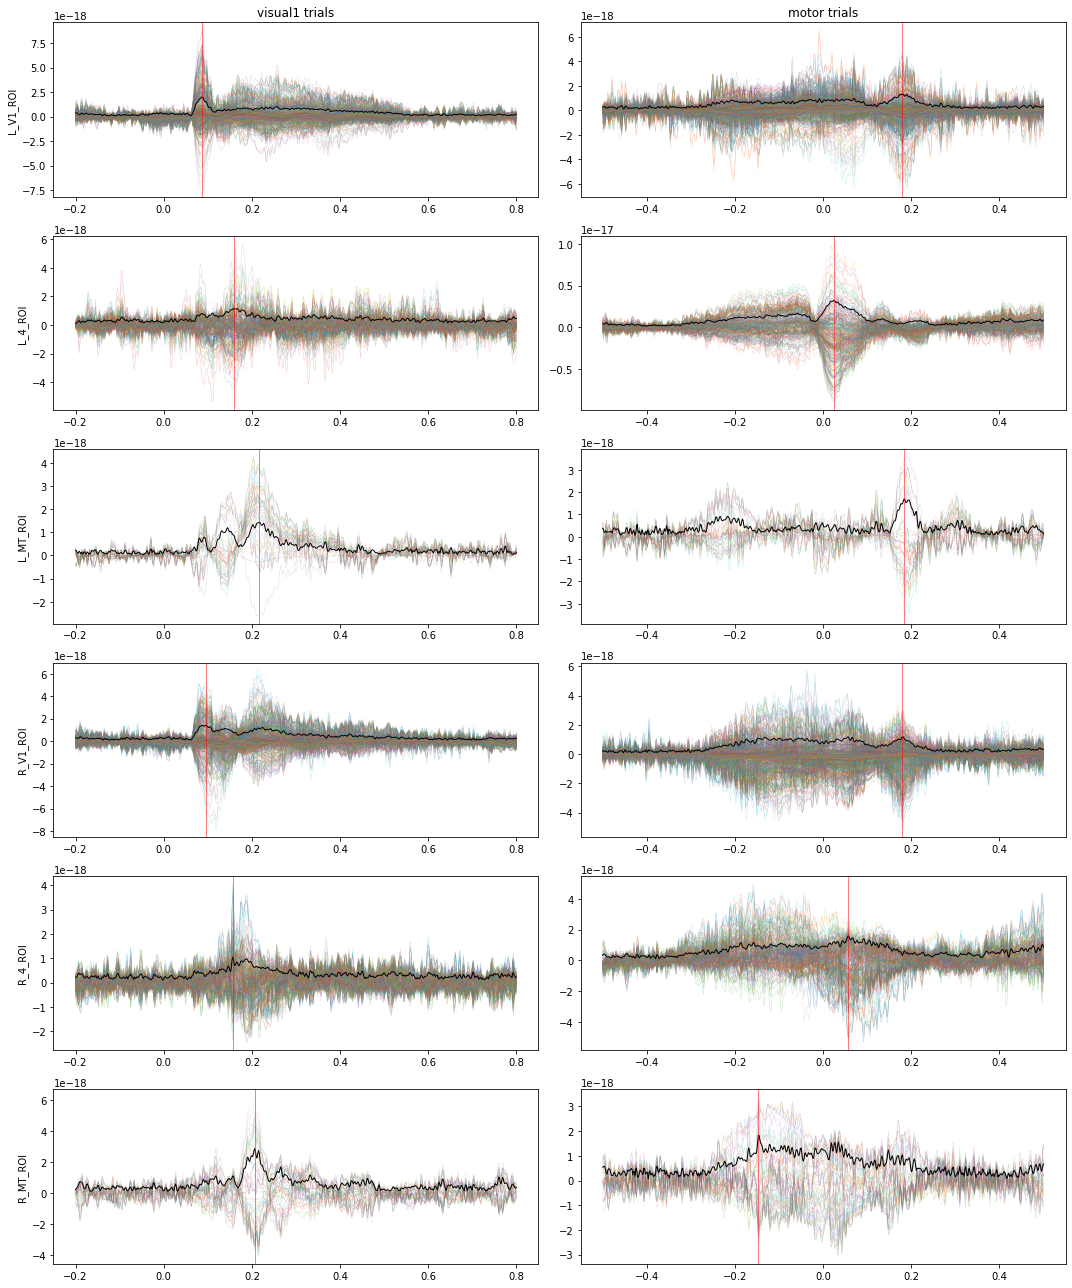

In [56]:
%matplotlib inline
f, ax = plt.subplots(len(target_labels), 2, figsize=(15,3*len(target_labels)))
ax[0, 0].set_title("visual1 trials")
ax[0, 1].set_title("motor trials")
gfp_peaks = {}
for ix, lab in enumerate(target_labels):
    ax[ix, 0].set_ylabel(lab)
    
    vis_data = source_vis[0][ROI_maps[lab]]
    gfp_vis = np.std(vis_data, axis=0)
    gfp_vis_peak = np.argmax(gfp_vis)
    mot_data = source_mot[0][ROI_maps[lab]]
    gfp_mot = np.std(mot_data, axis=0)
    gfp_mot_peak = np.argmax(gfp_mot)
    
    ax[ix, 0].plot(vis_epochs_times, vis_data.T, lw=0.4, alpha=0.3)
    ax[ix, 0].plot(vis_epochs_times, gfp_vis, lw=1, c="black")
    ax[ix, 0].axvline(vis_epochs_times[gfp_vis_peak], lw=0.5, c="red")
    ax[ix, 1].plot(mot_epochs_times, mot_data.T, lw=0.4, alpha=0.3)
    ax[ix, 1].plot(mot_epochs_times, gfp_mot, lw=1, c="black")
    ax[ix, 1].axvline(mot_epochs_times[gfp_mot_peak], lw=0.5, c="red")
    
    gfp_peaks[lab] = [gfp_vis_peak, gfp_mot_peak]
    
plt.tight_layout()

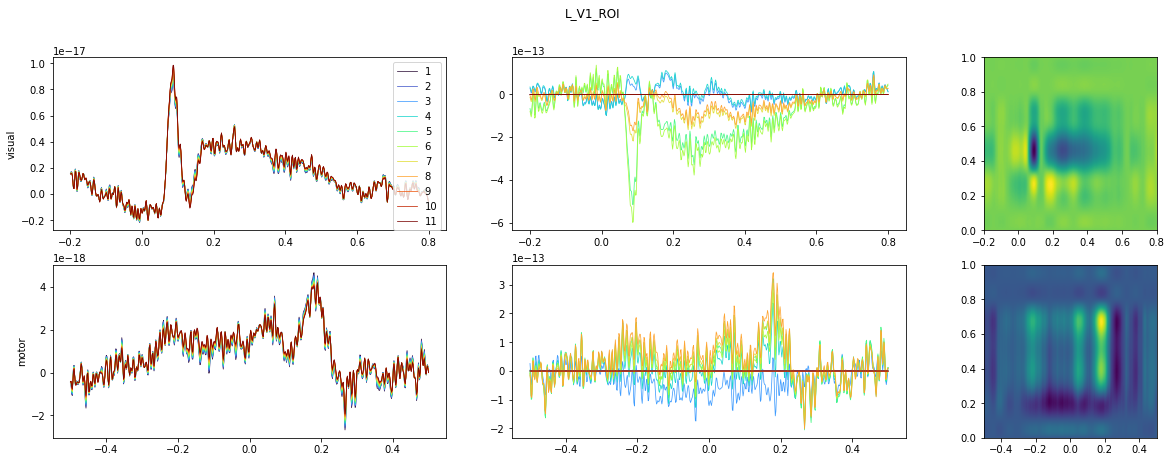

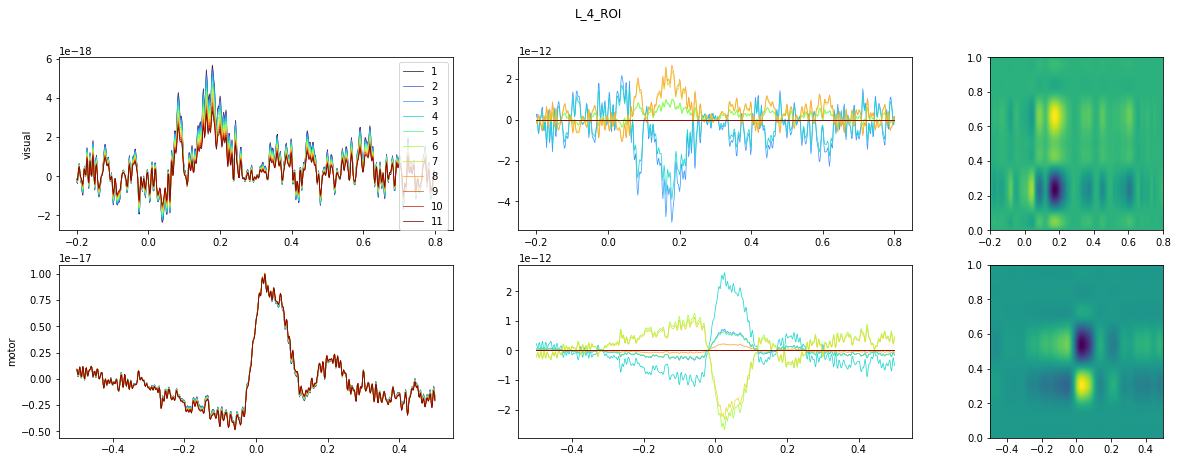

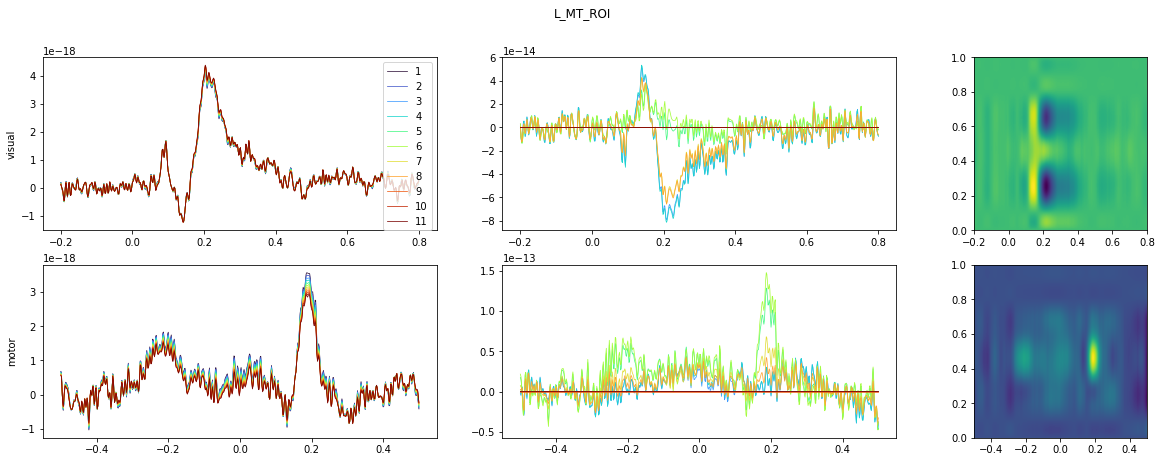

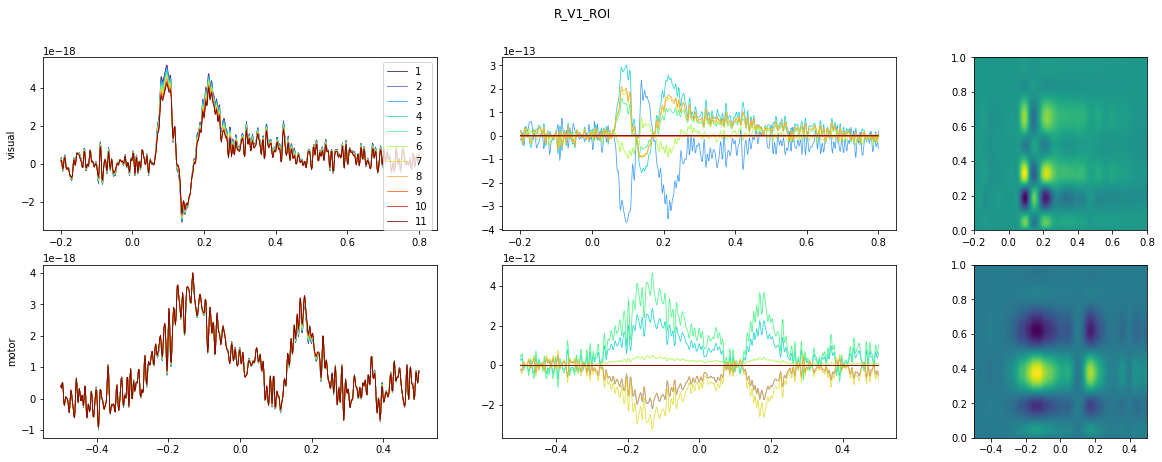

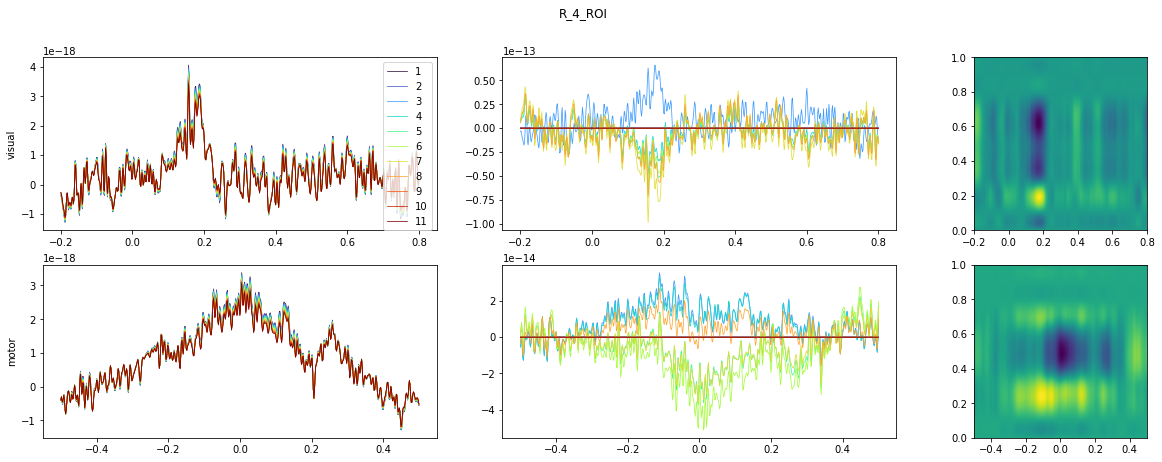

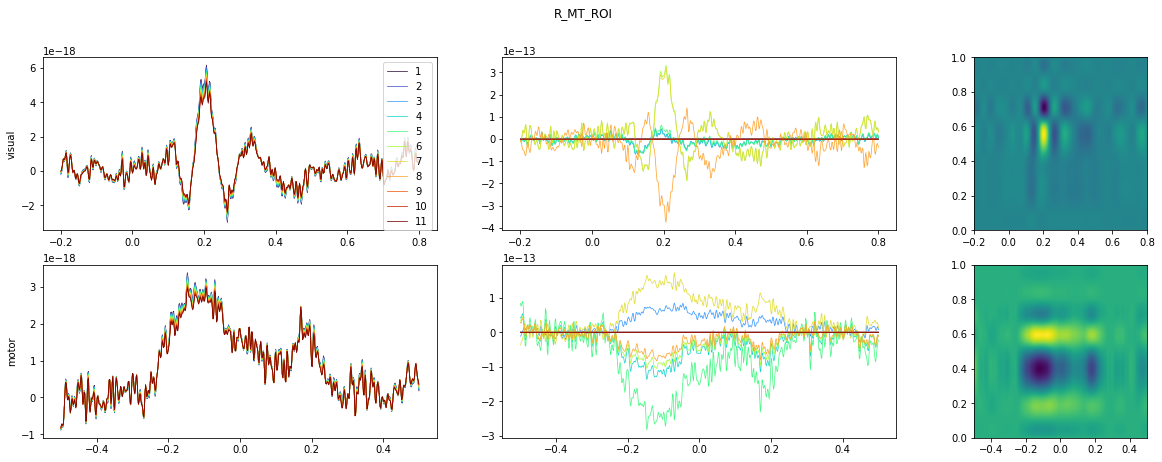

In [82]:
n_surfs = 11
colour_range = plt.cm.turbo(np.linspace(0, 1, num=n_surfs))

%matplotlib inline
for ix, lab in enumerate(target_labels):
    vis_top_vx = np.argmax(source_vis[0][ROI_maps[lab]][:,gfp_peaks[lab][0]])
    vis_data4csd = np.array([i[ROI_maps[lab]][vis_top_vx] for i in source_vis])
    mot_top_vx = np.argmax(source_mot[0][ROI_maps[lab]][:,gfp_peaks[lab][1]])
    mot_data4csd = np.array([i[ROI_maps[lab]][mot_top_vx] for i in source_mot])
    vis_distance = distance_ROI[ROI_maps[lab]][vis_top_vx] / (n_surfs -1)
    mot_distance = distance_ROI[ROI_maps[lab]][mot_top_vx] / (n_surfs -1)
    
    vis_csd = compute_csd(vis_data4csd, vis_epochs_times, vis_distance, n_surfs)
    mot_csd = compute_csd(mot_data4csd, mot_epochs_times, mot_distance, n_surfs)
    vis_csd_smooth = smooth_csd(vis_csd, n_surfs)
    mot_csd_smooth = smooth_csd(mot_csd, n_surfs)
    
    f, ax = plt.subplots(2, 3, figsize=(20,7), gridspec_kw={'width_ratios': [0.4, 0.4, 0.2]})
    f.suptitle(lab)
    ax[0,0].set_ylabel("visual")
    ax[1,0].set_ylabel("motor")
    
    for s in range(n_surfs):
        ax[0,0].plot(vis_epochs_times, vis_data4csd[s], lw=0.75, c=colour_range[s], label=s+1)
        ax[1,0].plot(mot_epochs_times, mot_data4csd[s], lw=0.75, c=colour_range[s], label=s+1)
        ax[0,1].plot(vis_epochs_times, vis_csd[s], lw=0.75, c=colour_range[s], label=s+1)
        ax[1,1].plot(mot_epochs_times, mot_csd[s], lw=0.75, c=colour_range[s], label=s+1)
    
    ax[0,2].imshow(vis_csd_smooth, origin="lower", extent=[vis_epochs_times[0], vis_epochs_times[-1], 0, 1])
    ax[1,2].imshow(mot_csd_smooth, origin="lower", extent=[mot_epochs_times[0], mot_epochs_times[-1], 0, 1])
    
    ax[0,0].legend();

In [83]:
source_mot[0].shape

(32166, 601)